This is an Image-Captioning project, where the goal is to generate captions successfully for images in the test set. For this task, we chose the relatively smaller dataset, the Flickr8k Dataset of Kaggle, compared to other available datasets. The images are encoded using Vision Transformer (ViT), while the caption data is preprocessed using the BERT tokenizer and then encoded using BERT. The encoded images and captions are then combined and fed into a Transformer for encoding to generate predicted captions.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
FOLDERNAME = "PUC_Rio/DL/Image_Captioning"
assert FOLDERNAME is not None, "[!] Enter the foldername."

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

In [ ]:
%cd drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/PUC_Rio/DL/Image_Captioning


In [ ]:
# %ls

In [ ]:
#location of the data
data_location =  "../Image_Captioning/flickr8k"
!ls $data_location

captions.txt  Images


Overview the dataset

In [ ]:
import os
import csv
import spacy
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
from collections import Counter, defaultdict
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset, Subset


from PIL import Image

caption_file = data_location + '/captions.txt'

df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))

df.head()

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Remove the comments, and run the code to see the images along with their corresponding captions.

In [ ]:
# #select any index from the whole dataset
# #single image has 5 captions
# #so, select indx as: 0,5,10,15...
# data_idx = 0

# image_path = data_location+"/Images/"+df.iloc[data_idx,0]   # row, column
# img=mpimg.imread(image_path)
# plt.imshow(img)
# plt.show()

# #image consits of 5 captions,
# for i in range(data_idx,data_idx+5):
#     print("Caption:",df.iloc[i,1])

### Dataset

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00


Data preprocessing

In [ ]:
import os
import csv
import torch
from PIL import Image
from torch import randperm
from torch.utils.data import Dataset
from transformers import BertTokenizer
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, caption_file, tokenizer, max_length):
        self.image_folder = image_folder
        self.caption_file = caption_file
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.vocab_size = self.tokenizer.vocab_size       # Get vocabulary size

        self.image_paths, self.captions = self.load_data()


    def load_data(self):
        image_paths = []
        captions = []

        with open(self.caption_file, 'r') as f:
            rd = csv.reader(f, delimiter=',')
            next(rd) # Ignore header

            for row in rd:
                image_name, caption = row
                image_path = os.path.join(self.image_folder, image_name)
                image_paths.append(image_path)
                captions.append(caption)

        caption_lengths = []
        for caption in captions:
            words = ['<start>'] + caption.split(' ') + ['<end>']
            caption_length = len(words)
            caption_lengths.append(caption_length)

        self.caption_lengths = caption_lengths

        return image_paths, captions


    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        caption = self.captions[idx]
        caption_lengths = self.caption_lengths[idx]

        image = Image.open(image_path).convert('RGB')
        image = self.transform_image(image)

        encoded_input = self.tokenizer.encode_plus(
            caption,
            add_special_tokens=True,      # <CLS>, <SEP>, <PAD>..
            padding='max_length',         # Use <pad> to fill up
            truncation=True,              # Length > max will be cut
            max_length=self.max_length,
            return_tensors='pt'           # py: pytorch
        )

        # Getting id for every single word including special tokens
        # if shape=[batch_size, sequence_length], after squeeze()=>[sequence_length]
        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        # Return dict
        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'target': input_ids
        }, caption_lengths

    def transform_image(self, image):

        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])

        return transform(image)


    # To avoid same datas in both train_set and test_set
    def random_split(self, train_portion=0.8, seed=42):
        img_files = list(set(self.image_paths))
        n_images = len(img_files)

        # This is completed dataset
        train_set_n_images = int(n_images * train_portion)
        test_set_n_images = n_images - train_set_n_images

        # If you need smaller number of dataset to test code, using this
        # train_set_n_images = int(n_images * train_portion * 0.1)  # multiply by 0.1 to reduce the number of images
        # test_set_n_images = int(n_images * (1 - train_portion) * 0.1)  # multiply by 0.1 to reduce the number of images


        img_idx = torch.randperm(n_images, generator=torch.Generator().manual_seed(seed)).tolist()

        train_img_idx, test_img_idx = img_idx[:train_set_n_images], img_idx[train_set_n_images:train_set_n_images + test_set_n_images]
        train_idx = [j for i in train_img_idx for j in self.get_image_indices(img_files[i])]
        test_idx = [j for i in test_img_idx for j in self.get_image_indices(img_files[i])]

        train_set = Subset(self, train_idx)
        test_set = Subset(self, test_idx)

        return train_set, test_set



### To test class Flickr8kDataset()

To see if everthing of class Flickr8kDataset goes well

In [ ]:
# import matplotlib.pyplot as plt

# image_folder = "../Image_Captioning/flickr8k/Images"
# caption_file = "../Image_Captioning/flickr8k/captions.txt"

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# max_length = 40
# dataset = Flickr8kDataset(image_folder, caption_file, tokenizer, max_length)

# # Take the first image and its first caption
# sample = dataset[0]
# image = sample['image']
# caption = sample['captions']

# image = image.permute(1, 2, 0).numpy()
# image = (image * 0.225 + 0.45).clip(0, 1)

# plt.imshow(image)
# plt.axis('off')
# plt.title(caption)
# plt.show()

In [ ]:
# dataset.random_split()

In [ ]:
# from torch.utils.data import DataLoader
# train_set, test_set = dataset.random_split(train_portion=0.8)
# train_dataloader = DataLoader(train_set, batch_size=200, shuffle=True)
# test_dataloader = DataLoader(test_set, batch_size=200)
# train_shape = next(iter(train_dataloader))

In [ ]:
# print('image_shape:', train_shape['image'].shape)
# print('input_ids_shape:', train_shape['input_ids'].shape)
# print('attention_mask_shape:', train_shape['attention_mask'].shape)

image_shape: torch.Size([256, 3, 224, 224])

input_ids_shape: torch.Size([256, 40])

attention_mask_shape: torch.Size([256, 40])

In [ ]:
torch.manual_seed(201)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cuda


In [ ]:
if hasattr(torch.cuda, 'empty_cache'):
    torch.cuda.empty_cache()

### Models

Image encoder model

In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

class ImageEncoder(nn.Module):
    def __init__(self, device, pretrained_model):
        super(ImageEncoder, self).__init__()

        self.device = device

        self.vit = ViTModel.from_pretrained(pretrained_model)

        # To freezen parameters of pretrained model
        for param in self.vit.parameters():
            param.requires_grad = False

        # self.hidden_dim = 768
        self.hidden_dim = self.vit.config.hidden_size

    def forward(self, imgs):

        imgs = imgs.to(self.device)

        encoded_imgs = self.vit(imgs)

        # (batch_size, sequence_length, hidden_dim) -> (batch_size, 197, 768)
        return encoded_imgs.last_hidden_state   # this is a attribute from pytorch

* The first step, encoding the ids (captions tokenized into number)
* Second,Fusion the images embeded features with captions embeded features
* The last, deconde combined fetures and transfer to predictions

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Transformer
from transformers import AutoModel, AutoConfig
from torch.nn import TransformerDecoderLayer, TransformerDecoder
import torch.nn.functional as F


class ImageCaptionDecoder(nn.Module):
    def __init__(self, device, encoder_dim, decoder_dim, bert_model_name, d_model, nhead, num_layers, batch_size, n_vocab, dropout):
        super(ImageCaptionDecoder, self).__init__()

        self.device = device
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.d_model = d_model
        self.nhead = nhead
        self.batch_size = batch_size
        self.n_vocab = n_vocab

        # self.max_caption_length = None  # Initialize as None

        # Load the pre-trained BERT model
        bert_config = AutoConfig.from_pretrained(bert_model_name)
        bert_config.output_hidden_states = True  # To access hidden states
        self.bert = AutoModel.from_pretrained(bert_model_name, config=bert_config)

        # Additional layers for decoding
        self.fc_image = nn.Linear(encoder_dim, d_model)  # (in, out) Projection layer for image features
        self.fc_bert = nn.Linear(bert_config.hidden_size, d_model)  # Projection layer for BERT embeddings

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.fc_combined = nn.Linear(encoder_dim, d_model)

        self.fc_output = nn.Linear(d_model, n_vocab)

        self.activation = nn.Tanh()

        self.dropout = nn.Dropout(dropout)

    def forward(self, encoded_images, input_ids, attention_mask):

        # Run the BERT model
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Extract the BERT output embeddings
        bert_embeddings = bert_output.last_hidden_state           # (batch_size, 40, 768)

        # Encoded_image = bert_embeddings[:, :projected_bert.size(1), :]
        if encoded_images.size(1) > bert_embeddings.size(1):
          encoded_images = encoded_images[:, :bert_embeddings.size(1)]

        # Combine image with caption features
        combined_features = encoded_images + bert_embeddings      # (batch_size, sequence_length, encoder_dim)
        combined_features = self.fc_combined(combined_features)   # (batch_size, 40, 768)
        combined_features = self.activation(combined_features)
        encoded_images = self.fc_image(encoded_images)            # (bath_size, 40, 512)

        # For Transformer decoder to acept, the shape shall be (sequence_length, batch_size, decode_dim)
        combined_features = combined_features.permute(1, 0, 2).contiguous()
        encoded_images = encoded_images.permute(1, 0, 2).contiguous()

        # # Run the Transformer decoder
        decoder_output_t = self.transformer(combined_features, memory=encoded_images)

        decoder_output_t = decoder_output_t.transpose(0, 1)       # (batch_size, 40, d_model)

        # Project the decoder output to the desired output dimension (n_vocab)
        decoder_output = self.fc_output(decoder_output_t)
        decoder_output = self.dropout(self.fc_output(decoder_output_t))


        return decoder_output



### Training

Loading saved checkpoint when:
* The training process was interrupted
* More training epochs need to be added

In [ ]:
def load_checkpoint(encoder, decoder, enc_optimizer, dec_optimizer, checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)

    # Load encoder state dict
    encoder.load_state_dict(checkpoint['encoder_state_dict'])

    # Load decoder state dict
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # Load optimizer state dicts
    enc_optimizer.load_state_dict(checkpoint['enc_optimizer_state_dict'])
    dec_optimizer.load_state_dict(checkpoint['dec_optimizer_state_dict'])

    # Load other training parameters
    start_epoch = checkpoint['epoch']
    losses = checkpoint['losses']

    return start_epoch, losses

Train process - using Cross Entropy loss

In [ ]:
import torch
import torch.nn.functional as F
from datetime import datetime
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(encoder, decoder, enc_optimizer, dec_optimizer, train_dataloader, dataset, checkpoint_path, epoch, tokenizer, save_path, num_epoch):
    encoder.train()
    decoder.train()

    # This is bert tokenizer vocab number
    n_vocab = dataset.vocab_size

    train_epoch_losses_list = []

    # Used to specify the computation ignoring this label in the loss function
    pad_token_idx = tokenizer.convert_tokens_to_ids('<pad>')

    total_loss = 0.0

    for batch_idx, (batch, caption_lengths) in enumerate(train_dataloader):
        images = batch['image'].to(device)                                    # (b, c, h, w)
        input_ids = batch['input_ids'].to(device)                             # (b, sequence_length)
        attention_mask = batch['attention_mask'].to(device)                   # (b, s)

        max_caption_length = max(caption_lengths)
        input_ids = input_ids[:, :max_caption_length]
        attention_mask = attention_mask[:, :max_caption_length]

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        # Forward pass
        encoded_images = encoder(images)                                      # (batch_size, sequence_length, hidden_dim)
        decoder_output = decoder(encoded_images, input_ids, attention_mask)   # (batch_size*sequce_length, hidden_dim)

        # Remove the <CLS>
        target = input_ids[:, 1:].to(device)                                  # (batch_size, sequence_length-1)
        target = target.reshape(-1)                                           # (batch_size*(sequence_length-1),)

        # Remove the <CLS>
        decoder_output = decoder_output[:, 1:]

        # Flatten the decoder_output and target for computing the loss
        decoder_output_new = decoder_output.reshape(-1, n_vocab)

        # Compute loss
        loss = F.cross_entropy(decoder_output_new, target, ignore_index=pad_token_idx)

        # Backward pass
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()

        train_epoch_losses_list.append(loss.item())
        total_loss += loss.item()

        if batch_idx % 30 == 0:
            print(f"Epoch [{epoch+1}/{num_epoch}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    epoch_loss = total_loss / len(train_dataloader)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}")


    # Save encoder and decoder checkpoint
    current_datetime = datetime.datetime.now().strftime("%Y-%m-%d")
    file_name = f"checkpoint_{current_datetime}_epoch_{epoch+1}.pt"
    checkpoint_file = os.path.join(save_path, file_name)

    torch.save({
        'epoch': epoch,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'enc_optimizer_state_dict': enc_optimizer.state_dict(),
        'dec_optimizer_state_dict': dec_optimizer.state_dict(),
        'losses': epoch_loss
    }, checkpoint_file)


    return epoch_loss, train_epoch_losses_list



BLEU (Bilingual Evaluation Understudy) is a commonly used metric for evaluating natural language processing (NLP) tasks, especially in machine translation. Its calculation involves comparing the similarity between sentences generated by a model and reference sentences to assess the model's performance.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_bleu_score(references, predictions):
    references = [[ref.split()] for ref in references]
    predictions = [pred.split() for pred in predictions]
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, predictions, smoothing_function=smoothie)

Test process - to evaluate the result of training of each epoch
* Using Cross Entropy loss
* Generate predicted caption
* Using BLEU to get the similarity score between prediction and original caption
* Print one image and original/predicted caption correspond


In [ ]:
def test(encoder, decoder, test_dataloader, dataset, epoch, tokenizer, batch_size):

    encoder.eval()
    decoder.eval()

    n_vocab = dataset.vocab_size

    pad_token_idx = dataset.tokenizer.convert_tokens_to_ids('<pad>')

    total_loss = 0
    test_epoch_losses_list = []
    pred_captions = []
    references = []

    with torch.no_grad():
        for batch_idx, (batch, caption_lengths) in enumerate(test_dataloader):
          images = batch['image'].to(device)                                    # (b, c, h, w)
          input_ids = batch['input_ids'].to(device)                             # (b, sequence_length)
          attention_mask = batch['attention_mask'].to(device)                   # (b, s)

          max_caption_length = max(caption_lengths)
          input_ids = input_ids[:, :max_caption_length]
          attention_mask = attention_mask[:, :max_caption_length]

          encoded_images = encoder(images)
          decoder_output = decoder(encoded_images, input_ids, attention_mask)

          target = input_ids[:, 1:].to(device)
          target = target.reshape(-1)

          decoder_output = decoder_output[:, 1:]
          _, preds = decoder_output.max(dim=-1)
          decoder_output = decoder_output.reshape(-1, n_vocab)

          loss = F.cross_entropy(decoder_output, target, ignore_index=pad_token_idx)
          test_epoch_losses_list.append(loss.item())
          total_loss += loss.item()

          # Convert predictions to captions
          preds = preds[:, :max_caption_length]
          for pred in preds:
            pred_caption = dataset.tokenizer.decode(pred, skip_special_tokens=True)
            pred_captions.append(pred_caption)

          # Gather references for BLEU score
          for caption in batch['input_ids']:
            caption_text = dataset.tokenizer.decode(caption, skip_special_tokens=True)
            references.append(caption_text)

          if (epoch+1) % 1 == 0 and batch_idx == 0:     # Take the first data of first batch of each epoch
            _, preds = decoder_output.max(dim=-1)       # -1->the last dimension to find the max
            preds = preds.view(batch_size, -1)          # System will inferr the dimension and keep same as original
            image = images[0].cpu().permute(1, 2, 0)    # Take the first image (h, w, c)
            image = (image * 0.225 + 0.45).clip(0, 1)   # To normalize pixel values
            pred_caption = dataset.tokenizer.decode(preds[0], skip_special_tokens=True)
            original_caption = dataset.tokenizer.decode(input_ids[0], skip_special_tokens=True)

            plt.figure(figsize=(3, 3))
            plt.imshow(image)
            plt.title("Image at epoch {}".format(epoch+1))
            plt.show()

            # Print the original caption
            original_caption = dataset.tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True)
            print(f'Original Caption: {original_caption}')

            # Print the generated caption
            generated_caption = dataset.tokenizer.decode(preds[0], skip_special_tokens=True)
            print(f'Generated Caption: {generated_caption}')

            # Save the captions to a text file during training
            with open("captions.txt", 'a') as f:
              f.write(f'Epoch: {epoch+1}\n')
              f.write(f'Original Caption: {original_caption}\n')
              f.write(f'Generated Caption: {generated_caption}\n\n')

            print('-'*100)
            print()


    avg_loss = total_loss / len(test_dataloader)
    print('Epoch {} Test Loss: {:.4f}'.format(epoch+1, avg_loss))


    # Compute BLEU score
    bleu_score = compute_bleu_score(references, pred_captions)
    print('BLEU Epoch {} Score: {:.6f}'.format(epoch+1, bleu_score))
    print('-*100')
    print()

    return avg_loss, bleu_score, test_epoch_losses_list



To create a Dataframe of training loss, test loss and BLEU score and save each data in csv during training

In [ ]:
def result_save(save_path, epoch, num_epoch, epoch_loss, avg_loss, bleu_score):

  if os.path.isfile(save_path):
    results_df = pd.read_csv(save_path)
  else:
    results_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Test Loss', 'BLEU Score'])

  results_df = results_df.append({
    'Epoch': epoch + 1,
    'Train Loss': epoch_loss,
    'Test Loss': avg_loss,
    'BLEU Score': bleu_score
  }, ignore_index=True)

  results_df.to_csv(save_path, index=False)


To save every data into each list during training to avoid training process interrupted, to let the data in the chart have continuity

In [ ]:
import pickle

def pickle_load_or_create_new(filename):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    else:
        return []


def pickle_dump(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

During the training process, several experiments were conducted to optimize the model performance:
* Adjusting the learning rate.
* Modifying the model architecture.
* Trying different dropout rates.
* Exploring various hidden dimensions.
* Experimenting with different numbers of * heads and layers.
* Testing different combinations of epochs and batch sizes.

Bert_vocab_size: 28996
Training set size: 32360
Test set size: 8095
----------------------------


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/10], Batch [1/324], Loss: 10.5252
Epoch [1/10], Batch [31/324], Loss: 5.8120
Epoch [1/10], Batch [61/324], Loss: 5.0397
Epoch [1/10], Batch [91/324], Loss: 4.5866
Epoch [1/10], Batch [121/324], Loss: 3.1567
Epoch [1/10], Batch [151/324], Loss: 3.3839
Epoch [1/10], Batch [181/324], Loss: 2.7164
Epoch [1/10], Batch [211/324], Loss: 2.2789
Epoch [1/10], Batch [241/324], Loss: 2.1304
Epoch [1/10], Batch [271/324], Loss: 1.8134
Epoch [1/10], Batch [301/324], Loss: 1.5817
Epoch 1, Train Loss: 3.2110


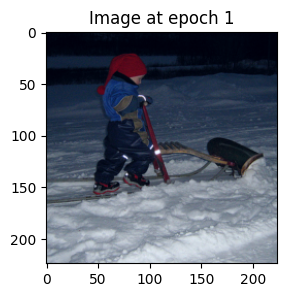

Original Caption: A small child wearing a red winter cap and a blue and black snowsuit pushing a plow through snow.
Generated Caption: A small child wearing a red snow to and a blue and black snow dog running a through snow.
----------------------------------------------------------------------------------------------------

Epoch 1 Test Loss: 1.3874
BLEU Epoch 1 Score: 0.357850
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


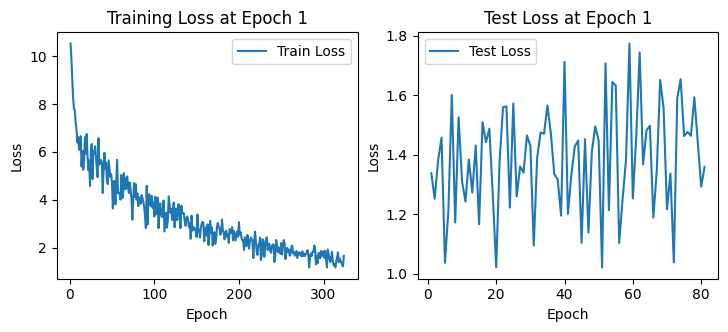

----------------------------------------------------------------------------------------------------

Epoch [2/10], Batch [1/324], Loss: 1.3414
Epoch [2/10], Batch [31/324], Loss: 0.8311
Epoch [2/10], Batch [61/324], Loss: 0.9133
Epoch [2/10], Batch [91/324], Loss: 1.0021
Epoch [2/10], Batch [121/324], Loss: 1.1187
Epoch [2/10], Batch [151/324], Loss: 1.0262
Epoch [2/10], Batch [181/324], Loss: 0.9448
Epoch [2/10], Batch [211/324], Loss: 0.8104
Epoch [2/10], Batch [241/324], Loss: 0.8257
Epoch [2/10], Batch [271/324], Loss: 0.7764
Epoch [2/10], Batch [301/324], Loss: 0.8772
Epoch 2, Train Loss: 0.9636


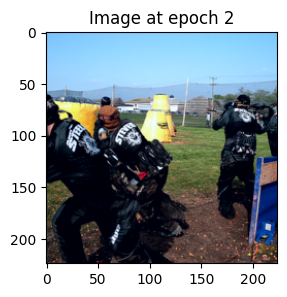

Original Caption: A bunch of guys in black play paintball.
Generated Caption: A boys of with in black play playing.
----------------------------------------------------------------------------------------------------

Epoch 2 Test Loss: 0.5951
BLEU Epoch 2 Score: 0.724525
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


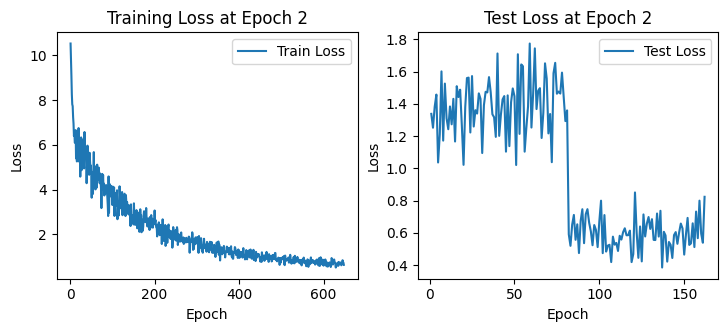

----------------------------------------------------------------------------------------------------

Epoch [3/10], Batch [1/324], Loss: 0.6294
Epoch [3/10], Batch [31/324], Loss: 0.6289
Epoch [3/10], Batch [61/324], Loss: 0.5424
Epoch [3/10], Batch [91/324], Loss: 0.5693
Epoch [3/10], Batch [121/324], Loss: 0.5212
Epoch [3/10], Batch [151/324], Loss: 0.6024
Epoch [3/10], Batch [181/324], Loss: 0.5522
Epoch [3/10], Batch [211/324], Loss: 0.5679
Epoch [3/10], Batch [241/324], Loss: 0.4491
Epoch [3/10], Batch [271/324], Loss: 0.3943
Epoch [3/10], Batch [301/324], Loss: 0.3382
Epoch 3, Train Loss: 0.5064


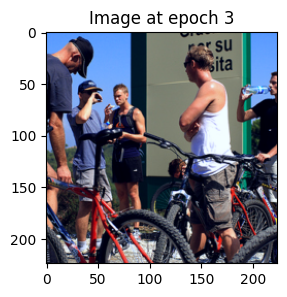

Original Caption: Men in athletic clothing stand near bicycles.
Generated Caption: Men in shorts clothing stand near bicycles.
----------------------------------------------------------------------------------------------------

Epoch 3 Test Loss: 0.3603
BLEU Epoch 3 Score: 0.836792
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


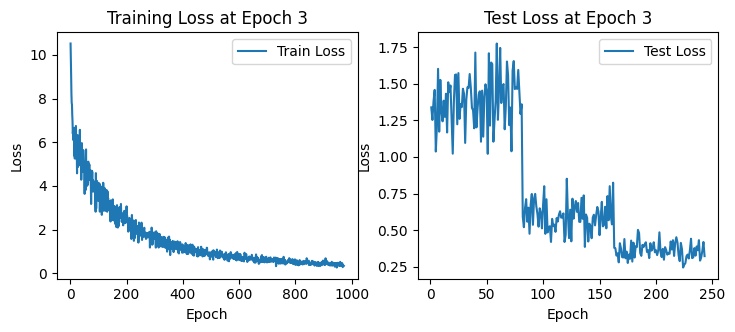

----------------------------------------------------------------------------------------------------

Epoch [4/10], Batch [1/324], Loss: 0.3221
Epoch [4/10], Batch [31/324], Loss: 0.3704
Epoch [4/10], Batch [61/324], Loss: 0.3716
Epoch [4/10], Batch [91/324], Loss: 0.3052
Epoch [4/10], Batch [121/324], Loss: 0.3802
Epoch [4/10], Batch [151/324], Loss: 0.2188
Epoch [4/10], Batch [181/324], Loss: 0.3692
Epoch [4/10], Batch [211/324], Loss: 0.4192
Epoch [4/10], Batch [241/324], Loss: 0.3843
Epoch [4/10], Batch [271/324], Loss: 0.2731
Epoch [4/10], Batch [301/324], Loss: 0.3523
Epoch 4, Train Loss: 0.3271


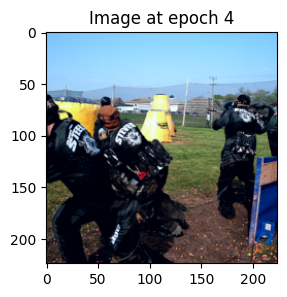

Original Caption: A bunch of guys in black play paintball.
Generated Caption: A bunch of guys in black play paintball.
----------------------------------------------------------------------------------------------------

Epoch 4 Test Loss: 0.2618
BLEU Epoch 4 Score: 0.887050
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


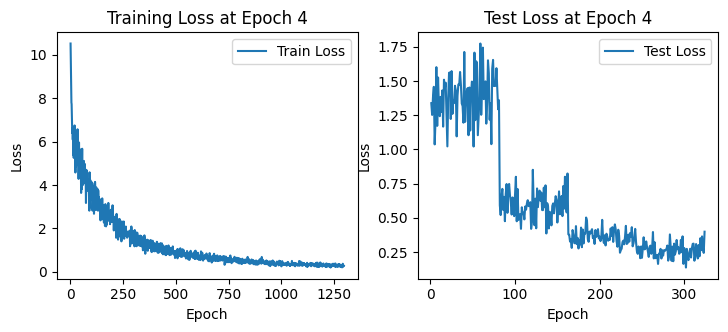

----------------------------------------------------------------------------------------------------

Epoch [5/10], Batch [1/324], Loss: 0.2713
Epoch [5/10], Batch [31/324], Loss: 0.2398
Epoch [5/10], Batch [61/324], Loss: 0.1606
Epoch [5/10], Batch [91/324], Loss: 0.2428
Epoch [5/10], Batch [121/324], Loss: 0.1749
Epoch [5/10], Batch [151/324], Loss: 0.2086
Epoch [5/10], Batch [181/324], Loss: 0.2489
Epoch [5/10], Batch [211/324], Loss: 0.2098
Epoch [5/10], Batch [241/324], Loss: 0.1892
Epoch [5/10], Batch [271/324], Loss: 0.2366
Epoch [5/10], Batch [301/324], Loss: 0.2187
Epoch 5, Train Loss: 0.2333


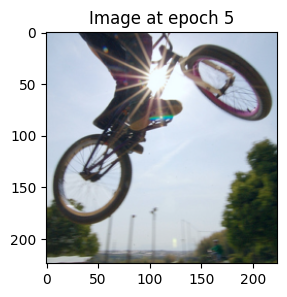

Original Caption: A person flying through the air on a bicycle.
Generated Caption: A person flying through the air on a bicycle.
----------------------------------------------------------------------------------------------------

Epoch 5 Test Loss: 0.2007
BLEU Epoch 5 Score: 0.913343
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


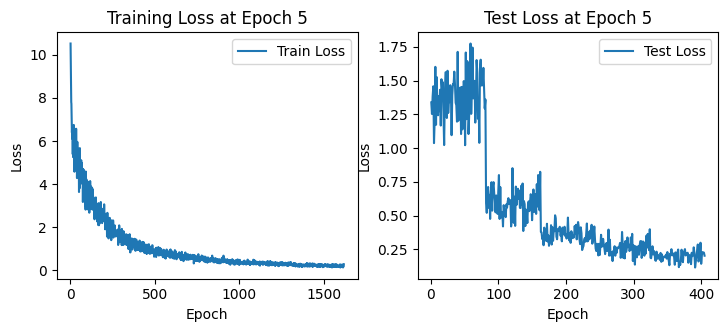

----------------------------------------------------------------------------------------------------

Epoch [6/10], Batch [1/324], Loss: 0.1837
Epoch [6/10], Batch [31/324], Loss: 0.1656
Epoch [6/10], Batch [61/324], Loss: 0.2090
Epoch [6/10], Batch [91/324], Loss: 0.1634
Epoch [6/10], Batch [121/324], Loss: 0.1834
Epoch [6/10], Batch [151/324], Loss: 0.1773
Epoch [6/10], Batch [181/324], Loss: 0.2094
Epoch [6/10], Batch [211/324], Loss: 0.1978
Epoch [6/10], Batch [241/324], Loss: 0.2118
Epoch [6/10], Batch [271/324], Loss: 0.1771
Epoch [6/10], Batch [301/324], Loss: 0.1875
Epoch 6, Train Loss: 0.1761


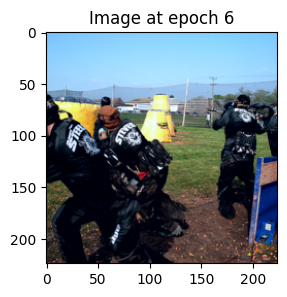

Original Caption: A bunch of guys in black play paintball.
Generated Caption: A bunch of guys in black play paintball.
----------------------------------------------------------------------------------------------------

Epoch 6 Test Loss: 0.1643
BLEU Epoch 6 Score: 0.930959
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


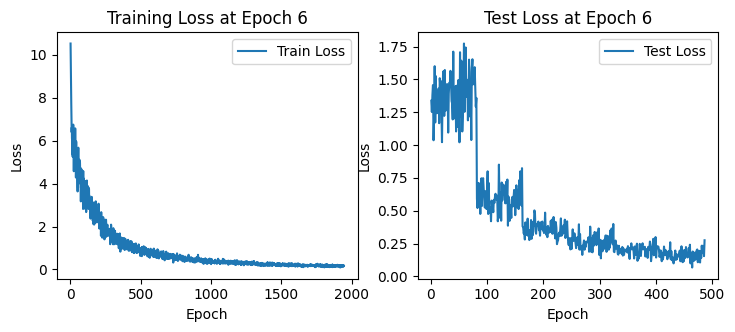

----------------------------------------------------------------------------------------------------

Epoch [7/10], Batch [1/324], Loss: 0.1458
Epoch [7/10], Batch [31/324], Loss: 0.1701
Epoch [7/10], Batch [61/324], Loss: 0.1298
Epoch [7/10], Batch [91/324], Loss: 0.1166
Epoch [7/10], Batch [121/324], Loss: 0.1552
Epoch [7/10], Batch [151/324], Loss: 0.1559
Epoch [7/10], Batch [181/324], Loss: 0.1591
Epoch [7/10], Batch [211/324], Loss: 0.1473
Epoch [7/10], Batch [241/324], Loss: 0.1233
Epoch [7/10], Batch [271/324], Loss: 0.1441
Epoch [7/10], Batch [301/324], Loss: 0.1138
Epoch 7, Train Loss: 0.1365


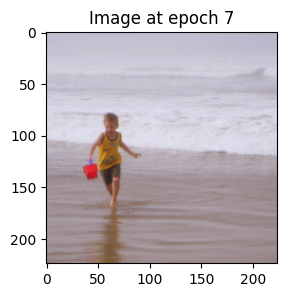

Original Caption: a little boy is running on the beach with a red bucket in his hand.
Generated Caption: a little boy is running on the beach with a red bucket in his hand.
----------------------------------------------------------------------------------------------------

Epoch 7 Test Loss: 0.1399
BLEU Epoch 7 Score: 0.941742
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


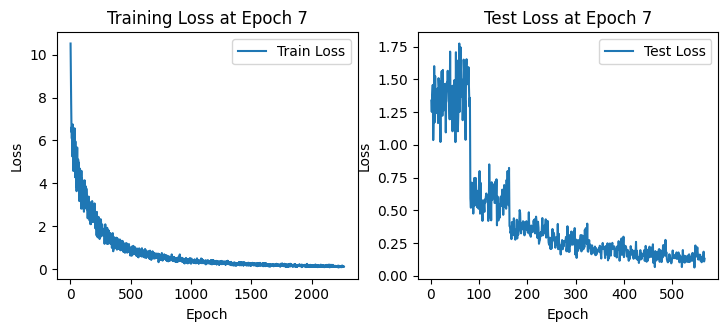

----------------------------------------------------------------------------------------------------

Epoch [8/10], Batch [1/324], Loss: 0.1098
Epoch [8/10], Batch [31/324], Loss: 0.1138
Epoch [8/10], Batch [61/324], Loss: 0.1214
Epoch [8/10], Batch [91/324], Loss: 0.1232
Epoch [8/10], Batch [121/324], Loss: 0.0875
Epoch [8/10], Batch [151/324], Loss: 0.1152
Epoch [8/10], Batch [181/324], Loss: 0.0938
Epoch [8/10], Batch [211/324], Loss: 0.0995
Epoch [8/10], Batch [241/324], Loss: 0.1358
Epoch [8/10], Batch [271/324], Loss: 0.1251
Epoch [8/10], Batch [301/324], Loss: 0.1097
Epoch 8, Train Loss: 0.1093


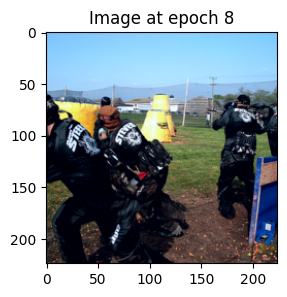

Original Caption: A bunch of guys in black play paintball.
Generated Caption: A bunch of guys in black play paintball.
----------------------------------------------------------------------------------------------------

Epoch 8 Test Loss: 0.1200
BLEU Epoch 8 Score: 0.949540
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


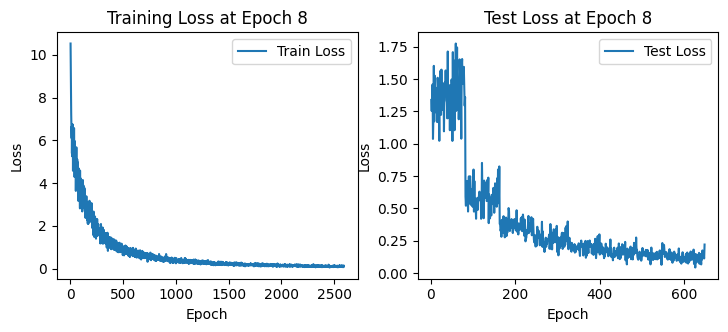

----------------------------------------------------------------------------------------------------

Epoch [9/10], Batch [1/324], Loss: 0.0841
Epoch [9/10], Batch [31/324], Loss: 0.1028
Epoch [9/10], Batch [61/324], Loss: 0.1303
Epoch [9/10], Batch [91/324], Loss: 0.0718
Epoch [9/10], Batch [121/324], Loss: 0.1072
Epoch [9/10], Batch [151/324], Loss: 0.0884
Epoch [9/10], Batch [181/324], Loss: 0.0767
Epoch [9/10], Batch [211/324], Loss: 0.0637
Epoch [9/10], Batch [241/324], Loss: 0.0607
Epoch [9/10], Batch [271/324], Loss: 0.0648
Epoch [9/10], Batch [301/324], Loss: 0.0731
Epoch 9, Train Loss: 0.0878


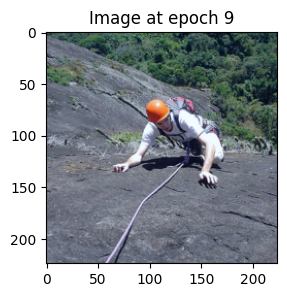

Original Caption: A man rock - climbing
Generated Caption: A man rock - climbing
----------------------------------------------------------------------------------------------------

Epoch 9 Test Loss: 0.1060
BLEU Epoch 9 Score: 0.957689
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


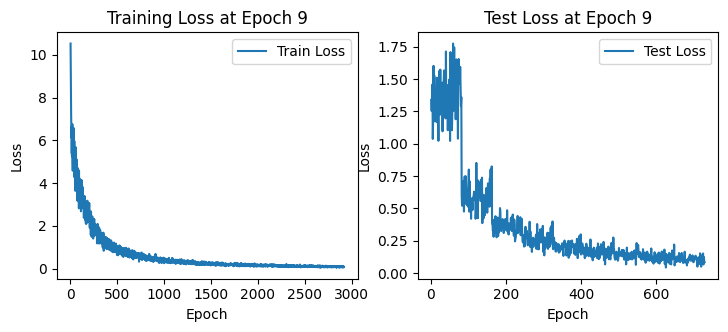

----------------------------------------------------------------------------------------------------

Epoch [10/10], Batch [1/324], Loss: 0.0777
Epoch [10/10], Batch [31/324], Loss: 0.0790
Epoch [10/10], Batch [61/324], Loss: 0.0867
Epoch [10/10], Batch [91/324], Loss: 0.0560
Epoch [10/10], Batch [121/324], Loss: 0.0645
Epoch [10/10], Batch [151/324], Loss: 0.0696
Epoch [10/10], Batch [181/324], Loss: 0.0708
Epoch [10/10], Batch [211/324], Loss: 0.0662
Epoch [10/10], Batch [241/324], Loss: 0.0933
Epoch [10/10], Batch [271/324], Loss: 0.0622
Epoch [10/10], Batch [301/324], Loss: 0.0883
Epoch 10, Train Loss: 0.0715


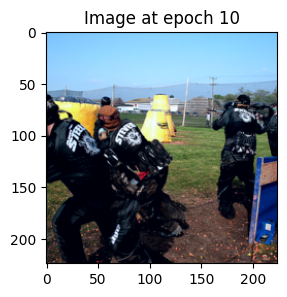

Original Caption: A bunch of guys in black play paintball.
Generated Caption: A bunch of guys in black play paintball.
----------------------------------------------------------------------------------------------------

Epoch 10 Test Loss: 0.0946
BLEU Epoch 10 Score: 0.961922
-*100



<ipython-input-23-8b0088ebf8b5>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


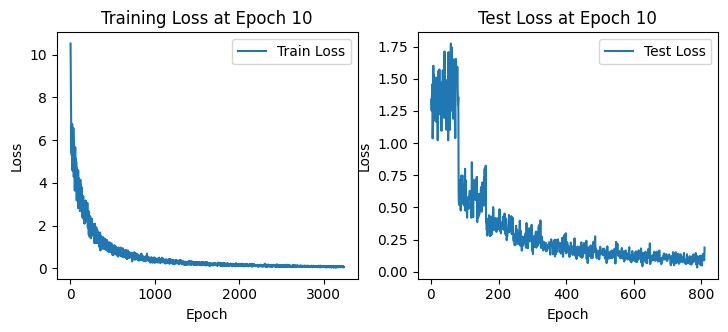

----------------------------------------------------------------------------------------------------


Model Performance
   Epoch  Train Loss  Test Loss  BLEU Score
0    1.0    3.210953   1.387447    0.357850
1    2.0    0.963553   0.595097    0.724525
2    3.0    0.506446   0.360317    0.836792
3    4.0    0.327100   0.261825    0.887050
4    5.0    0.233339   0.200712    0.913343
5    6.0    0.176115   0.164291    0.930959
6    7.0    0.136457   0.139869    0.941742
7    8.0    0.109343   0.119952    0.949540
8    9.0    0.087805   0.105983    0.957689
9   10.0    0.071539   0.094641    0.961922
----------------------------------------------------------------------------------------------------

The performance of Image-Caption model:


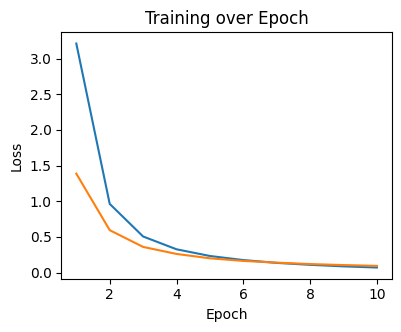

In [ ]:
import os
import torch
import pickle
import datetime
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt


img_root = "../Image_Captioning/flickr8k/Images"
cap_path = "../Image_Captioning/flickr8k/captions.txt"


def main():

    # Setting parameters
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    viT_pretrained_model = 'google/vit-base-patch16-224'
    max_length = 40
    batch_size = 100
    lr = 0.00003        # learning rate
    encoder_dim = 768
    decoder_dim = 512
    bert_model_name = 'bert-base-cased'
    d_model = 512       # hidden dim, (b, s_length, hidden_size)
    nhead = 8           # 8-16
    num_layers = 6      # 6-12
    save_path = "./model_checkpoints/"
    checkpoint_path = None
    num_epoch = 10
    start_epoch = 0
    dropout = 0.2
    save_loss_path = 'results_loss_bleu_dropout.csv'

    # Prepare data & split
    dataset = Flickr8kDataset(img_root, cap_path, tokenizer, max_length)
    n_vocab = dataset.vocab_size

    # Datas loading
    train_set, test_set = dataset.random_split(train_portion=0.8)
    train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_set, batch_size)

    print('Bert_vocab_size:', n_vocab)
    print('Training set size: {}'.format(len(train_set)))
    print('Test set size: {}'.format(len(test_set)))
    # print('Vocab size: {}'.format(len(dataset.vocab)))
    print('----------------------------')

    # # Create model & optimizer
    encoder = ImageEncoder(device, viT_pretrained_model).to(device)
    decoder = ImageCaptionDecoder(device, encoder_dim, decoder_dim, bert_model_name, d_model, nhead, num_layers, batch_size, n_vocab, dropout).to(device)
    enc_optimizer = torch.optim.Adam(encoder.parameters(), lr)
    dec_optimizer = torch.optim.Adam(decoder.parameters(), lr)

    # Load lists from files or create new ones if files don't exist
    train_every = pickle_load_or_create_new('train_every.pkl')
    test_every = pickle_load_or_create_new('test_every.pkl')
    bleu_scores = pickle_load_or_create_new('bleu_scores.pkl')
    train_total_losses = pickle_load_or_create_new('train_total_losses.pkl')
    test_total_losses = pickle_load_or_create_new('test_total_losses.pkl')

    if checkpoint_path is not None:
        # Load checkpoint and continue training from where it left off
        start_epoch, losses = load_checkpoint(encoder, decoder, enc_optimizer, dec_optimizer, checkpoint_path)
        start_epoch += 1  # Start from the next epoch


    shuffle=False
    for i in range(start_epoch, num_epoch):

        epoch = i

        if (epoch+1) % 1 == 0:
          shuffle = not shuffle
          test_dataloader = DataLoader(test_set, batch_size, shuffle=shuffle)

        # Train
        epoch_loss, train_epoch_losses_list = train(encoder, decoder, enc_optimizer, dec_optimizer, train_dataloader, dataset, checkpoint_path, epoch, tokenizer, save_path, num_epoch)
        train_total_losses.append(epoch_loss)
        train_every = train_every + train_epoch_losses_list

        encoder.to(device)
        decoder.to(device)

        # Test
        avg_loss, bleu_score, test_epoch_losses_list = test(encoder, decoder, test_dataloader, dataset, epoch, tokenizer, batch_size)
        test_every = test_every + test_epoch_losses_list
        test_total_losses.append(avg_loss)
        bleu_scores.append(bleu_score)

        # Save the updated lists back to files
        pickle_dump(train_every, 'train_every.pkl')
        pickle_dump(test_every, 'test_every.pkl')
        pickle_dump(bleu_scores, 'bleu_scores.pkl')
        pickle_dump(train_total_losses, 'train_total_losses.pkl')
        pickle_dump(test_total_losses, 'test_total_losses.pkl')


        # Save the updated dataframe back to file
        result_save(save_loss_path, epoch, num_epoch, epoch_loss, avg_loss, bleu_score)


        plt.figure(figsize=(6.4*4/3, 4.8*2/3))

        # Drawing Train loss from epoch 1 to the end
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_every)+1), train_every, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss at Epoch {}'.format(epoch+1))
        plt.legend()

        # Drawing Test loss from epoch 1 to the end
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(test_every)+1), test_every, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Test Loss at Epoch {}'.format(epoch+1))
        plt.legend()

        # Saving draws
        plt.savefig(f'train_test_loss_epoch_{epoch+1}.png')
        plt.show()
        print('-'*100)
        print()

    # Print train losses, test losses, and BLEU scores of total epochs
    print('='*100)
    print()
    results_df = pd.read_csv(save_loss_path)
    print('Model Performance')
    print(results_df)
    results_df.to_csv('model_performance.csv', index=False)


    # Plot final train/test loss
    print('-'*100)
    print()
    print('The performance of Image-Caption model:')
    plt.figure(figsize=(6.4*2/3, 4.8*2/3))
    plt.plot(range(1, num_epoch+1+start_epoch), train_total_losses, label='Train loss')
    plt.plot(range(1, num_epoch+1+start_epoch), test_total_losses, label='Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training over Epoch')
    plt.savefig('train_test_loss_final.png')
    plt.show()


if __name__ == '__main__':
  main()




###The model's performance and issues during training are as follows:

* During the training process, both train loss and test loss decreased rapidly, and the model was often able to generate correct captions during the test() function by epoch 3. To assess the model's similarity score, Bleu was used. Additionally, the test loss was monitored to observe its decreasing pattern, and after each epoch, the predicted captions were printed using the test() function.

> To address the possibility of overfitting, a demo program was created to visualize the generated captions for unseen images using the checkpoints from each epoch. However, the results revealed that no captions were produced.

> Despite the model's excellent performance in terms of loss and Bleu score, the inability to generate captions during the demo program indicates a potential issue that needs to be investigated further.

* To eliminate the possibility of the model not training successfully due to overfitting, I attempted to train the model with different dropout values (0.3, 0.4, 0.5). Despite varying the dropout rate, the test() function was still capable of generating perfect captions by epoch 3. However, when using the demo() function on unseen images, no captions were generated.

> This suggests that the issue might not be related to overfitting or the dropout rate but could be attributed to other factors affecting the model's performance during the generation of captions for unseen images. Further investigation is required to identify the root cause of the problem.

* I made a modification to the decoder model's structure: in the forward function, I rearranged the order of operations. Instead of converting the encoded image and encoded ids' hidden dimensions to the decoder dim before fusion, I first fused the encoded image and encoded ids, and then converted them to the decoder dim. After making this adjustment, the demo() function was able to generate captions for unseen images successfully.
>
        combined_features = encoded_images + bert_embeddings      # (batch_size, sequence_length, encoder_dim)
        combined_features = self.fc_combined(combined_features)   # (batch_size, 40, 768)
        combined_features = self.activation(combined_features)
        encoded_images = self.fc_image(encoded_images)

* Next, I retrained the model and tried various combinations and parameters, I will list three of the most representative ones:

> Tpye 1:
>
        batch_size = 100
        lr = 0.00003        
        encoder_dim = 768   
        decoder_dim = 512   
        d_model = 512       
        nhead = 8           
        num_layers = 6      
        num_epoch = 10

> Type 2:
>
        batch_size = 100
        lr = 0.00003        
        encoder_dim = 768   
        decoder_dim = 768   
        d_model = 768       
        nhead = 8           
        num_layers = 6      
        num_epoch = 8
>
> Type 3:
>
        batch_size = 100
        lr = 0.00003        
        encoder_dim = 768   
        decoder_dim = 512   
        d_model = 512       
        nhead = 16           
        num_layers = 8      
        num_epoch = 10
        dropout = 0.2

* The three approaches mentioned above all showed stable and consistent improvements in both train and test loss, with nearly perfect predictions generated by the test() function at epoch 3. However, when their respective checkpoints were used in the demo() function to generate captions for unseen images, the results were not very promising, with type1 showing the best performance.

> To further improve type3, I decided to train it for an additional 8 epochs. However, as the loss improvement became slower over time, I made the decision to increase the learning rate from 0.00003 to 0.0003 for the last 3 epochs.

> Added 5 epochs more to Type 3:

        batch_size = 100
        lr = 0.00003        
        encoder_dim = 768   
        decoder_dim = 512   
        d_model = 512       
        nhead = 16           
        num_layers = 8      
        num_epoch = 10+5
        dropout: 0.2

> Added 3 epochs more to Type 1 and increasing the lr:

        batch_size = 100
        lr = 0.0003        
        encoder_dim = 768   
        decoder_dim = 512   
        d_model = 512       
        nhead = 16           
        num_layers = 8      
        num_epoch = 15+3
        dropout = 0.2
        

* Increasing the training or raising the learning rate for Type3 did not improve the performance of the demo() function in generating captions for unseen images. The best result was achieved with Type 1. For evaluation purposes, I used a single fixed unseen image.

>
>

#### Interim conclusion: Due to limited available resources, I couldn't continue training with a hidden_dim of 768 (for the decoder) for more epochs. Analyzing the training results for Type1, the performance metrics such as train loss, test loss, and BLEU score were all good, and the generated captions during test() looked promising. Therefore, I didn't extend the training further. However, despite the positive indicators, the performance of demo() in generating captions for unseen images was not satisfactory. The generated captions from demo() contained some keywords representing the image, but the sentences lacked coherence. Apart from further optimizing the model, another possible factor contributing to this issue could be the limited dataset size, as the Flickr8k Dataset only consists of 8,091 images.

#### Below are some captions generated by demo() using Type 1 parameters with different chekpoints:

* cpation: looking her out with top out with puppy the their grass
* Caption: who air who air bench hanging hanging high hockey to bench in benchup suits running to bench hanging hanging hanging hanging hanging hanging hanging hanging hanging running
* Caption: drives which pre hand blond running sticking about fence other looks'blond which clothing looking sunny wooded Roller wearvas sharp fakeggy t bear girls square carcansuidlaid cowboy Lady catching nearby nearbykini fake
* Caption: who in bench man hill to bench to bench to bench to bench to air their to bench to bench to bench hanging to bench hanging running
* Caption: is is room color. surface covered surfaceies holding fancy the girl part tan holding cross fancy. staring people girl partly locker amidst mit fancy young his wearing playing

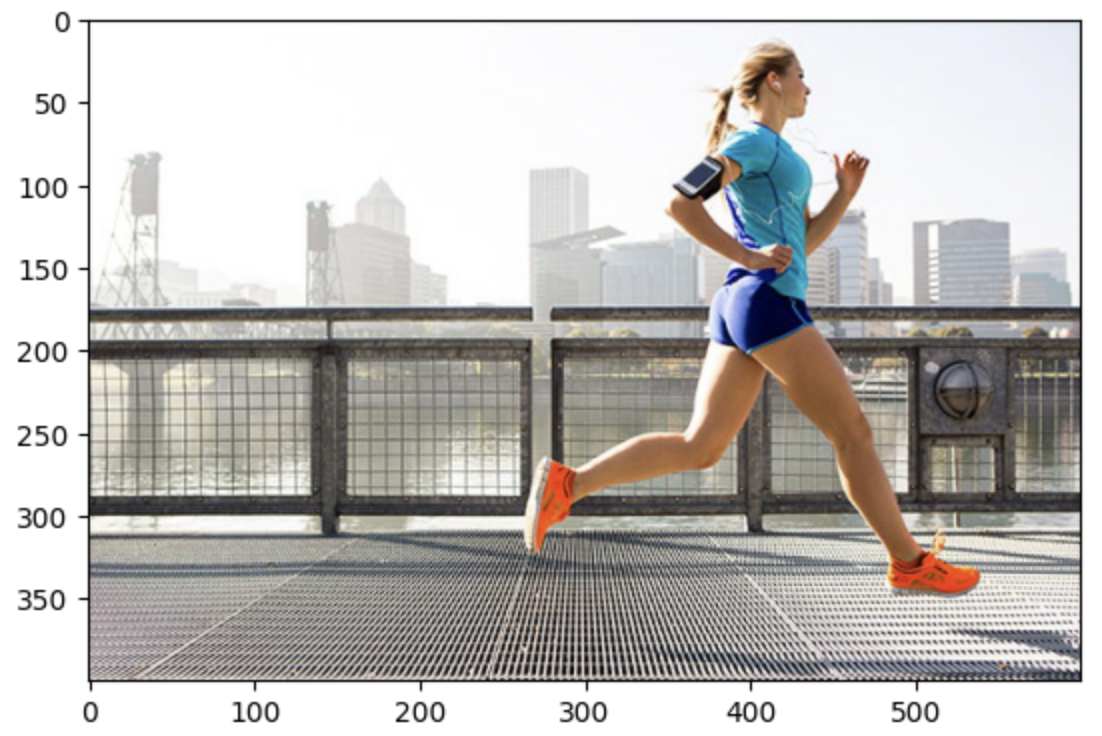